# Implement a tiny version of YOLO with DIOR dataset

## Import libraries

In [5]:
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Implement YOLO architecture

In [6]:
class LinearActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 1)

In [7]:
class TinyissimoYOLO(nn.Module):
    def __init__(self, B=2, num_classes=1, S=4):
        super(TinyissimoYOLO, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2,stride = 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2,stride = 2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fclayers(x)
        
        return x


model = TinyissimoYOLO()

In [8]:
summary(model, input_size=(1, 3, 88, 88))

Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLO                           [1, 112]                  --
├─Sequential: 1-1                        [1, 16, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 16, 88, 88]           448
│    └─LinearActivation: 2-2             [1, 16, 88, 88]           --
│    └─AvgPool2d: 2-3                    [1, 16, 44, 44]           --
├─Sequential: 1-2                        [1, 32, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 32, 44, 44]           4,640
│    └─LinearActivation: 2-5             [1, 32, 44, 44]           --
│    └─AvgPool2d: 2-6                    [1, 32, 22, 22]           --
├─Sequential: 1-3                        [1, 64, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 64, 22, 22]           18,496
│    └─LinearActivation: 2-8             [1, 64, 22, 22]           --
│    └─AvgPool2d: 2-9                    [1, 64, 11, 11]           --
├─Seque

## Utility Function

### Distance between centers

In [9]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

### Mean Average Precision

In [10]:
def is_center_inside_bbox(center, bbox):
    """
    Check if a center (x, y) is inside a bounding box (x, y, w, h).
    Parameters:
        center (tuple): The (x, y) coordinates of the center.
        bbox (tuple): The (x, y, w, h) coordinates of the bounding box.
    Returns:
        bool: True if the center is inside the bounding box, False otherwise.
    """
    center_x, center_y = center
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    bbox_x_min = bbox_x - bbox_w / 2
    bbox_x_max = bbox_x + bbox_w / 2
    bbox_y_min = bbox_y - bbox_h / 2
    bbox_y_max = bbox_y + bbox_h / 2

    return bbox_x_min <= center_x <= bbox_x_max and bbox_y_min <= center_y <= bbox_y_max


In [11]:
def mean_average_precision(
    pred_boxes, true_boxes, num_classes=1
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bbox
        specified as [train_idx, class_prediction, prob_score, x_center, y_center]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        specified as [train_idx, class_label, x, y, w, h]
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes 
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_match = False

            for idx, gt in enumerate(ground_truth_img):
                if is_center_inside_bbox(detection[3:5], gt[2:]):
                    best_match = True
                    best_gt_idx = idx
                    break

            if best_match:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)



### Non Max Suppression


In [12]:
def non_max_suppression(centers, threshold, distance_threshold):

    assert type(centers) == list
    centers = [center for center in centers if center[1]> threshold]
    centers = sorted(centers, key=lambda x: x[1], reverse=True)
    centers_after_nms = []

    while centers:
        current_center = centers.pop(0)
        centers = [
            center
            for center in centers
            if center[0] != current_center[0]
            or euclidean_distance(
                torch.tensor(current_center[3:5]).unsqueeze(0),
                torch.tensor(center[3:5]).unsqueeze(0),
            )
            > distance_threshold
        ]

        centers_after_nms.append(current_center)
        
    return centers_after_nms


### Get and convert centers

In [13]:
def get_bboxes(
    loader,
    model,
    threshold,
    distance_threshold,
    device="cuda",
):
    all_pred_centers = []
    all_true_centers = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels, boxes_list) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            predictions = model(x)

        
        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels) # type: ignore
        pred_centers = cellcenters_to_centers(predictions) # type: ignore
        
        

        for idx in range(batch_size):

            boxes = boxes_list[idx].to(device)

            # nms_centers= non_max_suppression(
            #     pred_centers[idx],
            #     threshold=threshold,
            #     distance_threshold=distance_threshold,
            # )

            # for center in nms_centers:
            #     all_pred_centers.append([train_idx] + center)

            for center in pred_centers[idx]:
                if center[1] > 0:
                    all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > 0:
                    all_true_centers.append([train_idx] + center)

            for box in boxes:
                all_true_boxes.append([train_idx] + box.tolist())

            train_idx += 1

    model.train()
    return all_pred_centers, all_true_centers, all_true_boxes


In [14]:
def convert_cellcenters(predictions, S=4, C=1):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )
    
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

In [15]:
def cellcenters_to_centers(out, S=4):
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)
        
    return all_centers

## Create Loader of Dataset

In [16]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((88, 88)), transforms.ToTensor()])

In [17]:
class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=4, B=2, C=1, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        self.img_dir = os.path.join(self.root_dir, 'images')
        self.label_dir = os.path.join(self.root_dir, 'label')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        boxes = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("RGB")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])
                boxes.append([class_label, x, y, width, height])
        
        if len(boxes) > 3:
            boxes = boxes[:3]
            centers = centers[:3]

        boxes = torch.tensor(boxes)
        centers = torch.tensor(centers)        
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix , boxes

## YOLO Loss

From original paper: 
>   YOLO predicts multiple bounding boxes per grid cell. At training time we only want one bounding box predictor to be responsible for each object. We assign one predictor to be “responsible” for predicting an object based on which prediction has the highest current IOU with the ground truth. This leads to specialization between the bounding box predictors.
Each predictor gets better at predicting certain sizes, aspect ratios, or classes of object, improving overall recall. 

$$
\begin{gathered}
\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2\right] \\
+\lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left[\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2\right] \\
+\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {obj }}\left(C_i-\hat{C}_i\right)^2 \\
+\lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{i j}^{\text {noobj }}\left(C_i-\hat{C}_i\right)^2 \\
+\sum_{i=0}^{S^2} \mathbb{1}_i^{\text {obj }} \sum_{c \in \text { classes }}\left(p_i(c)-\hat{p}_i(c)\right)^2
\end{gathered}
$$

During training we optimize the following, multi-part where $ 1_{obj}^i $ denotes if object appears in cell **i** and $1_{obj}^{ij}$ denotes that the **j**  bounding box predictor in cell i is “responsible” for that prediction.

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects. This can lead to model instability, as the model may prioritize learning to predict empty cells rather than focusing on correctly detecting objects in cells containing them, causing training to diverge early on. To remedy this, we increase the loss from bounding box coordinate predictions and decrease the loss from confidence predictions for boxes that don’t contain objects. We use two parameters, $\lambda_{coord}$ and $\lambda_{noobj}$  to accomplish this.

Note that the loss function only penalizes classification error if an object is present in that grid cell (hence the conditional class probability discussed earlier). It also only penalizes bounding box coordinate error if that predictor is “responsible” for the ground truth box (i.e. has the highest
IOU of any predictor in that grid cell).

In [18]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=4, B=2, C=1):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        iou_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        ious = torch.cat([iou_c1.unsqueeze(0), iou_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestcenter = torch.max(ious, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i
        
        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Training

In [19]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 100
LOAD_MODEL = False
LOAD_MODEL_FILE = "fomo.pth"

In [20]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y,boxes) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

### Combine all

In [21]:
def collate_fn(batch):
    images = []
    label_matrices = []
    boxes_list = []
    for item in batch:
        images.append(item[0])
        label_matrices.append(item[1])
        boxes_list.append(item[2])
    images = torch.stack(images)
    label_matrices = torch.stack(label_matrices)
    return images, label_matrices, boxes_list

In [22]:
from torch.utils.data import random_split


files_dir = 'one_class_data'
model = TinyissimoYOLO().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
loss_fn = YoloLoss()


train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=True
)


# Define the length of the training set
train_len = int(0.8 * len(train_dataset))

# Define the length of the test set
test_len = len(train_dataset) - train_len

# Split the dataset
train_dataset, test_dataset = random_split(train_dataset, [train_len, test_len])

# Now you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

/home/arch/ObjDct_Repo/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [23]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        train_loader, model, threshold=0.1, distance_threshold=0.1
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")

Epoch 1/100


100%|██████████| 28/28 [00:03<00:00,  9.16it/s, loss=100]


Mean loss was 179.2894641331264
mAP: 0.3618021607398987
Epoch 2/100


100%|██████████| 28/28 [00:02<00:00,  9.56it/s, loss=75.1]


Mean loss was 106.01712145124164
mAP: 0.3391192853450775
Epoch 3/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=41.7]


Mean loss was 71.89844635554722
mAP: 0.4143396019935608
Epoch 4/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=33.1]


Mean loss was 63.04528318132673
mAP: 0.3377811908721924
Epoch 5/100


100%|██████████| 28/28 [00:02<00:00,  9.67it/s, loss=52.4]


Mean loss was 59.23813056945801
mAP: 0.4039820432662964
Epoch 6/100


100%|██████████| 28/28 [00:02<00:00,  9.65it/s, loss=58.3]


Mean loss was 56.77009746006557
mAP: 0.4164489209651947
Epoch 7/100


100%|██████████| 28/28 [00:02<00:00,  9.69it/s, loss=40.7]


Mean loss was 55.149058886936736
mAP: 0.5047966837882996
Epoch 8/100


100%|██████████| 28/28 [00:02<00:00,  9.61it/s, loss=38.6]


Mean loss was 54.01202065604074
mAP: 0.4153566062450409
Epoch 9/100


100%|██████████| 28/28 [00:02<00:00,  9.70it/s, loss=36.1]


Mean loss was 53.29702990395682
mAP: 0.4965479373931885
Epoch 10/100


100%|██████████| 28/28 [00:02<00:00,  9.62it/s, loss=40.7]


Mean loss was 52.717609541756765
mAP: 0.3537937104701996
Epoch 11/100


100%|██████████| 28/28 [00:02<00:00,  9.71it/s, loss=35.4]


Mean loss was 52.404057366507395
mAP: 0.448469340801239
Epoch 12/100


100%|██████████| 28/28 [00:02<00:00,  9.68it/s, loss=40.9]


Mean loss was 52.140074729919434
mAP: 0.4738176167011261
Epoch 13/100


100%|██████████| 28/28 [00:02<00:00,  9.62it/s, loss=45.2]


Mean loss was 51.861739703587126
mAP: 0.49484360218048096
Epoch 14/100


100%|██████████| 28/28 [00:02<00:00,  9.67it/s, loss=44.1]


Mean loss was 51.449966294424875
mAP: 0.5081233382225037
Epoch 15/100


100%|██████████| 28/28 [00:02<00:00,  9.64it/s, loss=45]  


Mean loss was 51.31542655399868
mAP: 0.5043264627456665
Epoch 16/100


100%|██████████| 28/28 [00:02<00:00,  9.71it/s, loss=35.9]


Mean loss was 51.1848543712071
mAP: 0.4887242615222931
Epoch 17/100


100%|██████████| 28/28 [00:02<00:00,  9.54it/s, loss=35.3]


Mean loss was 50.87536266871861
mAP: 0.5549024343490601
Epoch 18/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=38.2]


Mean loss was 50.95702975136893
mAP: 0.4402002692222595
Epoch 19/100


100%|██████████| 28/28 [00:02<00:00,  9.64it/s, loss=44.8]


Mean loss was 50.656701360430034
mAP: 0.5378744602203369
Epoch 20/100


100%|██████████| 28/28 [00:02<00:00,  9.64it/s, loss=35.5]


Mean loss was 50.40839712960379
mAP: 0.5676244497299194
Epoch 21/100


100%|██████████| 28/28 [00:02<00:00,  9.68it/s, loss=37.6]


Mean loss was 50.42851734161377
mAP: 0.5752015709877014
Epoch 22/100


100%|██████████| 28/28 [00:02<00:00,  9.65it/s, loss=41]  


Mean loss was 50.3910128729684
mAP: 0.5702216029167175
Epoch 23/100


100%|██████████| 28/28 [00:02<00:00,  9.63it/s, loss=29.7]


Mean loss was 50.14455073220389
mAP: 0.48313233256340027
Epoch 24/100


100%|██████████| 28/28 [00:02<00:00,  9.66it/s, loss=42.8]


Mean loss was 50.067570958818706
mAP: 0.5635621547698975
Epoch 25/100


100%|██████████| 28/28 [00:02<00:00,  9.55it/s, loss=40.9]


Mean loss was 50.01555946895054
mAP: 0.5862026214599609
Epoch 26/100


100%|██████████| 28/28 [00:02<00:00,  9.59it/s, loss=46]  


Mean loss was 50.00349848611014
mAP: 0.5847446322441101
Epoch 27/100


100%|██████████| 28/28 [00:02<00:00,  9.60it/s, loss=44.5]


Mean loss was 49.80814797537668
mAP: 0.5869143009185791
Epoch 28/100


100%|██████████| 28/28 [00:02<00:00,  9.60it/s, loss=37.3]


Mean loss was 49.76255580357143
mAP: 0.5074425935745239
Epoch 29/100


100%|██████████| 28/28 [00:02<00:00,  9.63it/s, loss=32.3]


Mean loss was 49.82780524662563
mAP: 0.5940737128257751
Epoch 30/100


100%|██████████| 28/28 [00:03<00:00,  9.07it/s, loss=39.3]


Mean loss was 49.888557297842844
mAP: 0.5622046589851379
Epoch 31/100


100%|██████████| 28/28 [00:03<00:00,  8.80it/s, loss=37.4]


Mean loss was 49.677322796412874
mAP: 0.4976963996887207
Epoch 32/100


100%|██████████| 28/28 [00:03<00:00,  8.93it/s, loss=34.8]


Mean loss was 49.71958555494036
mAP: 0.5931949615478516
Epoch 33/100


100%|██████████| 28/28 [00:03<00:00,  9.10it/s, loss=38.4]


Mean loss was 49.69718728746687
mAP: 0.4964064359664917
Epoch 34/100


100%|██████████| 28/28 [00:03<00:00,  9.24it/s, loss=35.5]


Mean loss was 49.89608873639788
mAP: 0.5511354804039001
Epoch 35/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=43]  


Mean loss was 49.57251698630197
mAP: 0.4459593594074249
Epoch 36/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=46.6]


Mean loss was 49.55244473048619
mAP: 0.5229516625404358
Epoch 37/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=45.8]


Mean loss was 49.434915678841726
mAP: 0.5884321928024292
Epoch 38/100


100%|██████████| 28/28 [00:02<00:00,  9.56it/s, loss=37.5]


Mean loss was 49.57431493486677
mAP: 0.5844243168830872
Epoch 39/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=33.2]


Mean loss was 49.420568874904085
mAP: 0.4423474371433258
Epoch 40/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=41.2]


Mean loss was 49.280306816101074
mAP: 0.4247608780860901
Epoch 41/100


100%|██████████| 28/28 [00:03<00:00,  8.46it/s, loss=40.5]


Mean loss was 49.391360827854704
mAP: 0.5066418647766113
Epoch 42/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=36.3]


Mean loss was 49.335917472839355
mAP: 0.5494250655174255
Epoch 43/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=37]  


Mean loss was 49.39261777060373
mAP: 0.49376457929611206
Epoch 44/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=34.9]


Mean loss was 49.62103189740862
mAP: 0.5031922459602356
Epoch 45/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=32.8]


Mean loss was 49.23311519622803
mAP: 0.5843014717102051
Epoch 46/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=36.2]


Mean loss was 49.40741239275251
mAP: 0.4294871985912323
Epoch 47/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=34.6]


Mean loss was 49.30315889630999
mAP: 0.43803125619888306
Epoch 48/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=39.9]


Mean loss was 49.23646054949079
mAP: 0.5927718877792358
Epoch 49/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=31.6]


Mean loss was 49.14612007141113
mAP: 0.44565075635910034
Epoch 50/100


100%|██████████| 28/28 [00:03<00:00,  9.17it/s, loss=36.8]


Mean loss was 49.16287694658552
mAP: 0.57020103931427
Epoch 51/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=33.9]


Mean loss was 49.063074248177664
mAP: 0.5071690082550049
Epoch 52/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=36.3]


Mean loss was 49.07558604649135
mAP: 0.45322081446647644
Epoch 53/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=34.2]


Mean loss was 49.03742517743792
mAP: 0.5115848183631897
Epoch 54/100


100%|██████████| 28/28 [00:02<00:00,  9.54it/s, loss=46]  


Mean loss was 48.87329987117222
mAP: 0.5950696468353271
Epoch 55/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=35.7]


Mean loss was 48.91912160600935
mAP: 0.5873763561248779
Epoch 56/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=45.9]


Mean loss was 48.86186300005232
mAP: 0.48369359970092773
Epoch 57/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=32]  


Mean loss was 49.00687967027937
mAP: 0.5798168778419495
Epoch 58/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=35.5]


Mean loss was 48.93235111236572
mAP: 0.4859074056148529
Epoch 59/100


100%|██████████| 28/28 [00:03<00:00,  8.90it/s, loss=36.9]


Mean loss was 48.74133709498814
mAP: 0.5983890891075134
Epoch 60/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=41.1]


Mean loss was 48.82656955718994
mAP: 0.5403066277503967
Epoch 61/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=32.7]


Mean loss was 48.89184052603586
mAP: 0.478191077709198
Epoch 62/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=39.9]


Mean loss was 48.583437374659944
mAP: 0.5612120628356934
Epoch 63/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=46.1]


Mean loss was 48.455600193568635
mAP: 0.4846818447113037
Epoch 64/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=30.5]


Mean loss was 48.436160223824636
mAP: 0.550643265247345
Epoch 65/100


100%|██████████| 28/28 [00:02<00:00,  9.55it/s, loss=41.5]


Mean loss was 48.321020807538716
mAP: 0.5387557148933411
Epoch 66/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=37.7]


Mean loss was 48.47994899749756
mAP: 0.5136318802833557
Epoch 67/100


100%|██████████| 28/28 [00:02<00:00,  9.48it/s, loss=41.3]


Mean loss was 48.31685774666922
mAP: 0.5350223183631897
Epoch 68/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=39.5]


Mean loss was 48.34749344417027
mAP: 0.4974035322666168
Epoch 69/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=42.7]


Mean loss was 48.25040204184396
mAP: 0.471844881772995
Epoch 70/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=45.2]


Mean loss was 48.36309746333531
mAP: 0.5542279481887817
Epoch 71/100


100%|██████████| 28/28 [00:02<00:00,  9.53it/s, loss=41.6]


Mean loss was 48.2310425894601
mAP: 0.5904659628868103
Epoch 72/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=37.5]


Mean loss was 48.18779114314488
mAP: 0.5859584212303162
Epoch 73/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=47.8]


Mean loss was 48.13965320587158
mAP: 0.5044952034950256
Epoch 74/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=29.9]


Mean loss was 48.114608900887625
mAP: 0.4983193874359131
Epoch 75/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=38.9]


Mean loss was 47.99317060198103
mAP: 0.5347381830215454
Epoch 76/100


100%|██████████| 28/28 [00:02<00:00,  9.44it/s, loss=41.2]


Mean loss was 47.99298409053257
mAP: 0.5044601559638977
Epoch 77/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=55]  


Mean loss was 47.903259822300505
mAP: 0.5074084997177124
Epoch 78/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=33.6]


Mean loss was 47.89807346888951
mAP: 0.5550571084022522
Epoch 79/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=33]  


Mean loss was 47.97654179164341
mAP: 0.5258854627609253
Epoch 80/100


100%|██████████| 28/28 [00:02<00:00,  9.42it/s, loss=38.7]


Mean loss was 47.83904579707554
mAP: 0.5278202295303345
Epoch 81/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=36.9]


Mean loss was 47.88815416608538
mAP: 0.5353260040283203
Epoch 82/100


100%|██████████| 28/28 [00:02<00:00,  9.47it/s, loss=42.5]


Mean loss was 47.663921628679546
mAP: 0.5191854238510132
Epoch 83/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=38.7]


Mean loss was 47.63151809147426
mAP: 0.5187008380889893
Epoch 84/100


100%|██████████| 28/28 [00:02<00:00,  9.37it/s, loss=34.7]


Mean loss was 47.67621449061802
mAP: 0.5164057016372681
Epoch 85/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=35.5]


Mean loss was 47.573025703430176
mAP: 0.5685111880302429
Epoch 86/100


100%|██████████| 28/28 [00:02<00:00,  9.50it/s, loss=44.5]


Mean loss was 47.62068721226284
mAP: 0.5235593914985657
Epoch 87/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=36.6]


Mean loss was 47.62311363220215
mAP: 0.5472506880760193
Epoch 88/100


100%|██████████| 28/28 [00:02<00:00,  9.43it/s, loss=37.7]


Mean loss was 47.598521777561736
mAP: 0.5544291138648987
Epoch 89/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=36.4]


Mean loss was 47.46646513257708
mAP: 0.543787956237793
Epoch 90/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s, loss=32.7]


Mean loss was 47.37718268803188
mAP: 0.5390440821647644
Epoch 91/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=35.8]


Mean loss was 47.3934143611363
mAP: 0.5391781330108643
Epoch 92/100


100%|██████████| 28/28 [00:02<00:00,  9.52it/s, loss=39.1]


Mean loss was 47.275631359645296
mAP: 0.539341926574707
Epoch 93/100


100%|██████████| 28/28 [00:02<00:00,  9.33it/s, loss=35.1]


Mean loss was 47.263210024152485
mAP: 0.5497182011604309
Epoch 94/100


100%|██████████| 28/28 [00:02<00:00,  9.51it/s, loss=42.7]


Mean loss was 47.31690774645124
mAP: 0.5407590270042419
Epoch 95/100


100%|██████████| 28/28 [00:02<00:00,  9.45it/s, loss=34.2]


Mean loss was 47.2381649017334
mAP: 0.5677105188369751
Epoch 96/100


100%|██████████| 28/28 [00:02<00:00,  9.46it/s, loss=35.3]


Mean loss was 47.20728315625872
mAP: 0.5463276505470276
Epoch 97/100


100%|██████████| 28/28 [00:02<00:00,  9.49it/s, loss=42.6]


Mean loss was 47.26554911477225
mAP: 0.5582868456840515
Epoch 98/100


100%|██████████| 28/28 [00:02<00:00,  9.37it/s, loss=38.3]


Mean loss was 47.12296199798584
mAP: 0.5601545572280884
Epoch 99/100


100%|██████████| 28/28 [00:02<00:00,  9.51it/s, loss=28]  


Mean loss was 47.16478518077305
mAP: 0.5500228404998779
Epoch 100/100


100%|██████████| 28/28 [00:02<00:00,  9.55it/s, loss=35.2]


Mean loss was 47.148619651794434
mAP: 0.5423035621643066


In [24]:
len(pred_boxes), len(real_boxes)

(13760, 1095)

In [25]:
real_boxes[0]

[0,
 0.0,
 0.531000018119812,
 0.5211970210075378,
 0.8059999942779541,
 0.7431421279907227]

In [26]:
target_boxes[0]

[0, 0.0, 1.0, 0.531000018119812, 0.5211970210075378]

In [27]:
torch.save(model.state_dict(), "fomo.pth")

## Testing

### Load test set

### Load model and make inference

In [28]:

checkpoint = torch.load("fomo.pth")
# Load the state dictionary from the .pth file

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()


TinyissimoYOLO(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LinearActivation()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fclayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=256, bias=True)
    (2): LinearActivation()
    (3): Linear(in_features=256, out_features=112, bias=True)
  )
)

In [29]:
with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model, threshold = 0.1, distance_threshold=0.1
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")

mAP: 0.5861493349075317


In [73]:
def plot_centers(idx, pred_centers, target_centers):
    values = test_dataset[idx]
    image = values[0]
    image = image.permute(1, 2, 0).to("cpu")
    
    image = np.array(image)
    height, width, _ = image.shape
    p_centers = []
    t_centers = []
    for center in pred_centers:
        if center[0] == idx:
            p_centers.append(center[1:])
    
    for center in target_centers:
        if center[0] == idx:
            t_centers.append(center[1:])
    

    fig, ax = plt.subplots()
    ax.imshow(image)
    
    for center in p_centers:
        rect = patches.Rectangle(
            (center[2] * width , center[3] * height),
            1,
            1,
            linewidth=5,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    # Create a Rectangle patch
    for boxes in t_centers:
        class_label = int(boxes[0])
        box = boxes[1:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add class label text
        ax.text(upper_left_x * width, upper_left_y * height, str(class_label), color='r', fontsize=10, verticalalignment='bottom')

    
    plt.show()


In [71]:
print(len(pred_boxes))

3293


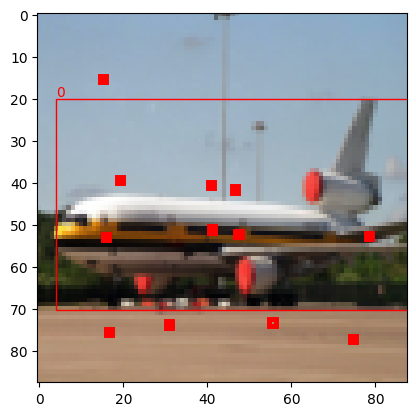

In [74]:
plot_centers(1, pred_boxes, real_boxes)

In red predicted, green true

In [ ]:
sample = torch.rand(1, 3, 256, 256).to(DEVICE)
model.eval()
output = model(sample)
print(output.shape)

In [ ]:

# Set the path to save the ONNX model
onnx_model_path = "fomo.onnx"

# Export the model to ONNX format
torch.onnx.export(model, sample, onnx_model_path)


# PYHELAYERS

## Select a subset of plain samples from test set

In [ ]:
test_img_list=[]
test_label_list=[]
for values in test_dataset:
    image = values[0]
    label = values[1]
    test_img_list.append(image)
    test_label_list.append(label)
    if len(test_img_list)==1:
        break

test_img_array = np.array(test_img_list)
test_label_array = np.array(test_label_list)
# test_img_array = test_img_array[:11728]
# test_label_array = test_label_array[:11728]
# test_img_array = test_img_array.reshape(733,16,3,64,64)
# test_label_array = test_label_array.reshape(733,16,7,7,30)
print(test_img_array.shape)
print(test_label_array.shape)

## Initialize he scheme

In [ ]:
import pyhelayers
import utilshe

utilshe.verify_memory()

print('Misc. initalizations')

In [ ]:
context = pyhelayers.DefaultContext()
print('HE context ready')

In [ ]:

nnp = pyhelayers.NeuralNetPlain()

In [ ]:
hyper_params = pyhelayers.PlainModelHyperParams()
nnp.init_from_files(hyper_params, ["fomo.onnx"])


In [ ]:
he_run_req = pyhelayers.HeRunRequirements()
he_run_req.set_he_context_options([pyhelayers.DefaultContext()])
he_run_req.optimize_for_batch_size(1)

profile = pyhelayers.HeModel.compile(nnp, he_run_req)
batch_size = profile.get_optimal_batch_size()
print('Profile ready. Batch size=',batch_size)

In [ ]:
profile.get_he_config_requirement()

In [ ]:
context = pyhelayers.HeModel.create_context(profile)
print('HE context initalized')

In [ ]:
context.get_scheme_name()

In [ ]:
context.get_default_scale()

In [ ]:
# context.get_library_name()

In [ ]:
# context.has_secret_key()

In [ ]:
# context.save_secret_key_to_file('secret_key.txt')

In [ ]:
nn = pyhelayers.NeuralNet(context)
nn.encode_encrypt(nnp, profile)
print('Encrypted network ready')

In [ ]:
plain_samples, labels = utilshe.extract_batch(test_img_array, test_label_array, batch_size, 0)

print('Batch of size',batch_size,'loaded')

In [ ]:
print(plain_samples.shape)
print(plain_samples.dtype)

In [ ]:
iop = nn.create_io_processor()
samples = pyhelayers.EncryptedData(context)
iop.encode_encrypt_inputs_for_predict(samples, [plain_samples])
print('Test data encrypted')

## Make prediction on encrypted data

In [ ]:
utilshe.start_timer()

predictions = pyhelayers.EncryptedData(context)
nn.predict(predictions, samples)

duration=utilshe.end_timer('predict')
utilshe.report_duration('predict per sample',duration/batch_size)

In [ ]:
plain_predictions_aHE = iop.decrypt_decode_output(predictions)
print(f"plain prediction shape after HE: {plain_predictions_aHE.shape}")

In [ ]:
type(plain_predictions_aHE)

In [ ]:
# ## In case I have test samples > batch size
# plain_predictions_aHE = plain_predictions_aHE.reshape(,1470)

## Evaluate prediction with HE

In [ ]:
plain_predictions_bHE=[]
for sample in test_img_array:
    tensor_sample = torch.tensor(sample).unsqueeze(0)
    output = model(tensor_sample)
    output = output.detach().numpy()
    plain_predictions_bHE.append(output)
plain_predictions_bHE = np.array(plain_predictions_bHE)
plain_predictions_bHE = plain_predictions_bHE.reshape(1, 441)
print(f"plain prediction shape before HE: {plain_predictions_bHE.shape}")


In [ ]:

# Compute the absolute differences between plain prediction before and after HE
differences = np.abs(plain_predictions_bHE - plain_predictions_aHE)

# Compute relevant statistics
mean_difference = np.mean(differences)
max_difference = np.max(differences)
min_difference = np.min(differences)
std_difference = np.std(differences)

print(f"Mean difference: {mean_difference}")
print(f"Max difference: {max_difference}")
print(f"Min difference: {min_difference}")
print(f"Std difference: {std_difference}")


### Convert prediction in bounding boxes

In [ ]:
def get_bboxes_from_prediction(
    predictions,
    test_image_array,
    iou_threshold,
    threshold,
):
    all_pred_boxes = []

    
    train_idx = 0

    bboxes = cellboxes_to_boxes(predictions)

    for idx in range(len(test_image_array)):
        image = test_image_array[idx]

        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
        )

        # Activate only for test
        if  idx == 0:
            plot_image(image.permute(1,2,0).to("cpu"), nms_boxes)

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        

        train_idx += 1

    return all_pred_boxes


In [ ]:
tensor_predaHE = torch.tensor(plain_predictions_aHE)
tensor_predbHE = torch.tensor(plain_predictions_bHE)
tensor_imgs = torch.tensor(test_img_array)

print("Prediction before HE")
bboxes_aHE = get_bboxes_from_prediction(tensor_predbHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)

print("Prediction after HE")
bboxes_bHE = get_bboxes_from_prediction(tensor_predaHE, tensor_imgs, iou_threshold=0.5, threshold=0.4)